This notebook uses TabDDPM but adds a VAE encoder and decoder layer before and after the main TabDDPM, making it a Latent Diffusion Model(LDM).

In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [3]:
import sys
sys.path.append("../src/tab_ddpm/")

In [4]:
from gaussian_multinomial_diffusion import GaussianMultinomialDiffusion
from modules import MLPDiffusion

In [5]:
sys.path.append("../src/")
from vae_model import vae
from loss_functions import get_kld_loss, coral, compute_covariance, ZINORMLoss
from ffnzinb_model import ffnzinb

In [6]:
device = torch.device("cuda:0")

In [7]:
# seed things
random.seed(0)
np.random.seed(0)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

### Load Datasets

#### Cell Lines

In [8]:
cl_train_df = pd.read_csv("../data/diffusion_pretraining/cl_diffusion_train_sample0.csv", index_col=0)
cl_train_df.shape

(1569, 7776)

In [9]:
cl_test_df = pd.read_csv("../data/diffusion_pretraining/cl_diffusion_test_sample0.csv", index_col=0)
cl_test_df.shape

(175, 7776)

In [10]:
cl_train_dataset = TensorDataset(torch.tensor(cl_train_df.values), torch.tensor(cl_train_df.values))

In [11]:
cl_test_dataset = TensorDataset(torch.tensor(cl_test_df.values), torch.tensor(cl_test_df.values))

In [12]:
cl_train_dataloader = DataLoader(cl_train_dataset, batch_size=128, shuffle=True, num_workers=1, worker_init_fn=seed_worker, generator=g,)

In [13]:
cl_test_dataloader = DataLoader(cl_test_dataset, batch_size=128, shuffle=False, num_workers=1, worker_init_fn=seed_worker, generator=g,)

#### Patient Dataset

In [14]:
tcga_train_df = pd.read_csv("../data/diffusion_pretraining/tcga_diffusion_train_sample0.csv", index_col=0)
tcga_train_df.shape

(476, 7776)

In [15]:
tcga_test_df = pd.read_csv("../data/diffusion_pretraining/tcga_diffusion_test_sample0.csv", index_col=0)
tcga_test_df.shape

(120, 7776)

In [16]:
tcga_train_dataset = TensorDataset(torch.tensor(tcga_train_df.values), torch.tensor(tcga_train_df.values))

In [17]:
tcga_test_dataset = TensorDataset(torch.tensor(tcga_test_df.values), torch.tensor(tcga_test_df.values))

In [18]:
tcga_train_dataloader = DataLoader(tcga_train_dataset, batch_size=128, shuffle=True, num_workers=1, worker_init_fn=seed_worker, generator=g,)

In [19]:
tcga_test_dataloader = DataLoader(tcga_test_dataset, batch_size=128, shuffle=False, num_workers=1, worker_init_fn=seed_worker, generator=g,)

#### Patient Diffusion model - LDM variant

Add a Zinorm VAE before the input goes to the diffusion model.

##### Pretraining the VAE before it can be used with the DDPM

In [20]:
# pretraining VAE
def training_loop_vae(train_dataloader, epochs, vae, ffb_zinb_model, device, optimizer):
    train_losses = []
    for i in range(epochs):
        loss = 0.0
        avg_test_loss = ""
        for idx, batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            inp_vae = batch[0].to(device=device, dtype=torch.float32)
            enc, mu, logvar, inp_dec = vae(inp_vae) # From VAE encoder + reparameterization
            X_mu1, X_theta1, X_pi1 = ffb_zinb_model(inp_dec) # ZINorm 
            
            # mse_recon_loss = torch.nn.MSELoss()(inp_dec, inp_vae)
            loss_zin, t1, t2 = ZINORMLoss(reduction="mean")(X_mu1, X_theta1, X_pi1, inp_vae, lamda=1e-6)
            # print(loss_zin)
            kld_loss = get_kld_loss(mu, logvar, is_mean=True)
            total_loss = kld_loss + loss_zin
            
            # total_loss = kld_loss + mse_recon_loss
            total_loss.backward()
            optimizer.step()
            loss += total_loss.detach().item()

        print(f"|Epoch {i} | Average VAE training loss: {loss/(idx+1)} |")
        train_losses.append(loss/(idx+1))
    return train_losses

In [21]:
patient_vae = vae(input_dim=7776, k_list=[1024, 128], actf_list=["relu", "relu"], is_real=True).to(device)
patient_ffb_zinb_model = ffnzinb(input_dim=7776).to(device)

U: encoder 
Sequential(
  (enc-0): Linear(in_features=7776, out_features=1024, bias=True)
  (act-0): ReLU()
  (enc-1): Linear(in_features=1024, out_features=128, bias=True)
  (act-1): ReLU()
)
#
mu_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
sigma_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
U: decoder 
Sequential(
  (-dec-0): Linear(in_features=64, out_features=128, bias=True)
  (-act-0): ReLU()
  (dec-0): Linear(in_features=128, out_features=1024, bias=True)
  (act-0): ReLU()
  (dec-1): Linear(in_features=1024, out_features=7776, bias=True)
  (act-1): ReLU()
)
#
zinb_layers_mu: 
OrderedDict([('mu', Linear(in_features=7776, out_features=7776, bias=True))])
#
zinb_layers_theta: 
OrderedDict([('theta', Linear(in_features=7776, out_features=7776, bias=True))])
#
zinb_layers_pi: 
OrderedDict([('pi', Linear(in_features=7776, out_features=7776, bias=True)), ('pi-actf', Sigmoid())])
#


In [22]:
patient_vae.to(device)
params = list(patient_ffb_zinb_model.parameters()) + list(patient_vae.parameters())
optimizer = torch.optim.Adam(params, lr=1e-4, weight_decay=1e-4)
train_losses = training_loop_vae(tcga_train_dataloader, 100, patient_vae, patient_ffb_zinb_model, device, optimizer)

|Epoch 0 | Average VAE training loss: 4199547655.875 |
|Epoch 1 | Average VAE training loss: 3759044992.0 |
|Epoch 2 | Average VAE training loss: 3775889728.0 |
|Epoch 3 | Average VAE training loss: 3349209307.34375 |
|Epoch 4 | Average VAE training loss: 1855770788.234375 |
|Epoch 5 | Average VAE training loss: 1613609675.65625 |
|Epoch 6 | Average VAE training loss: 1763040223.9921875 |
|Epoch 7 | Average VAE training loss: 1412944693.5 |
|Epoch 8 | Average VAE training loss: 1963576705.3046875 |
|Epoch 9 | Average VAE training loss: 720367547.828125 |
|Epoch 10 | Average VAE training loss: 837334789.515625 |
|Epoch 11 | Average VAE training loss: 2723018380.1328125 |
|Epoch 12 | Average VAE training loss: 758830411.6328125 |
|Epoch 13 | Average VAE training loss: 1766398867.046875 |
|Epoch 14 | Average VAE training loss: 932959155.0 |
|Epoch 15 | Average VAE training loss: 568972470.59375 |
|Epoch 16 | Average VAE training loss: 741795089.640625 |
|Epoch 17 | Average VAE training lo

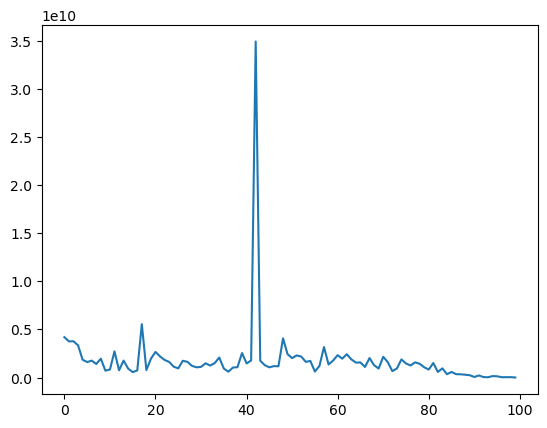

In [23]:
plt.plot(train_losses)

##### Training the LDM model with above VAE

In [24]:
# testing function with LDM
def testing_loop_ldm(test_dataloader, diffusion_model, vae, ffn_zinb_model, device):
    avg_test_loss = 0.0
    for idx, batch in enumerate(test_dataloader):
        with torch.no_grad():
            inp_vae = batch[0].to(device=device, dtype=torch.float32)
            inp, mu, logvar, _ = vae(inp_vae) # From VAE encoder + reparameterization
            
            noise = torch.randn_like(inp).to(device) # this is the label we use   
            b = inp.shape[0]
            t, pt = diffusion_model.sample_time(b, device, 'uniform')
            inp_t = diffusion_model.gaussian_q_sample(inp, t, noise) # forward process
            model_out = diffusion_model._denoise_fn(inp_t, t) # predicted epsilon

            # MSE between predicted inp_pred after reverse diffusion and original input
            inp_pred = diffusion_model._predict_xstart_from_eps(inp_t, t, model_out)
            out_vae = vae.decoder(inp_pred) # after VAE decoding
            X_mu1, X_theta1, X_pi1 = ffn_zinb_model(out_vae) # ZINorm
            mse_recon_loss = torch.nn.MSELoss()(X_mu1, inp_vae) # MSE after ensuring it follows the ZIN distribution

            avg_test_loss += mse_recon_loss.detach().item()

    return avg_test_loss/(idx+1)

In [25]:
# training function with LDM
def training_loop_ldm(train_dataloader, test_dataloader, epochs, diffusion_model, vae, ffn_zinb_model, device, optimizer, scheduler=None):
    train_losses = []
    for i in range(epochs):
        loss = 0.0
        avg_test_loss = ""
        for idx, batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            inp_vae = batch[0].to(device=device, dtype=torch.float32)
            inp, mu, logvar, inp_dec = vae(inp_vae) # From VAE encoder + reparameterization
            # X_mu1, X_theta1, X_pi1 = ffn_zinb_model(inp_dec) # ZINorm
            
            noise = torch.randn_like(inp).to(device) # this is the label we use   
            b = inp.shape[0]
            t, pt = diffusion_model.sample_time(b, device, 'uniform')
            inp_t = diffusion_model.gaussian_q_sample(inp, t, noise) # forward process
            model_out = diffusion_model._denoise_fn(inp_t, t) # predicted epsilon
            # loss calculation using MSE between predicted and actual noise
            loss_gauss = diffusion_model._gaussian_loss(model_out, inp, inp_t, t, noise).mean()

            # reconstruct inp, pass through VAE decoder and calculate VAE losses
            inp_pred = diffusion_model._predict_xstart_from_eps(inp_t, t, model_out)
            out_vae = vae.decoder(inp_pred) # after VAE decoding
            # mse_recon_loss = torch.nn.MSELoss()(out_vae, inp_vae)
            X_mu1, X_theta1, X_pi1 = ffn_zinb_model(out_vae)
            # print(torch.isinf(X_mu1).sum())
            
            loss_zin, t1, t2 = ZINORMLoss(reduction="mean")(X_mu1, X_theta1, X_pi1, inp_vae, lamda=1e-4)
            kld_loss = get_kld_loss(mu, logvar, is_mean=True)
            # print(loss_zin)
            # print(torch.isinf(t1).sum())
            # print(torch.isinf(t2).sum())

            # total_loss = loss_gauss + mse_recon_loss + kld_loss
            total_loss = 0.5 * loss_gauss + 0.3 * loss_zin + 0.2 * kld_loss
            
            total_loss.backward()
            # torch.nn.utils.clip_grad_norm_(list(tcga_diff_model.parameters()), 10)
            optimizer.step()
            if scheduler:
                scheduler.step()
            
            loss += total_loss.detach().item()

        if (i+1) % 10 == 0:
            avg_test_loss = f" Average testing loss: {testing_loop_ldm(test_dataloader, diffusion_model, vae, ffn_zinb_model, device)}"

        print(f"|Epoch {i} | Average training loss: {loss/(idx+1)} |{avg_test_loss}")
        train_losses.append(loss/(idx+1))
        
    return train_losses
            
            

In [26]:
tcga_mlp_diffusion_model = MLPDiffusion(d_in=64, num_classes=0, is_y_cond=False, rtdl_params={"d_layers": [16], "dropout": 0.1})
tcga_diff_model = GaussianMultinomialDiffusion(num_classes=np.array([0]), num_numerical_features=64, denoise_fn=tcga_mlp_diffusion_model)

In [27]:
device = torch.device("cuda")
tcga_diff_model.to(device)
# optimizer = torch.optim.Adam(list(tcga_diff_model.parameters()) + list(patient_vae.parameters()) + list(patient_ffb_zinb_model.parameters()), lr=1e-6)
optimizer = torch.optim.Adam(tcga_diff_model.parameters())
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
train_losses = training_loop_ldm(tcga_train_dataloader, tcga_test_dataloader, 20, tcga_diff_model, patient_vae, patient_ffb_zinb_model, device, optimizer, scheduler=None)

|Epoch 0 | Average training loss: 72875691267.25 |
|Epoch 1 | Average training loss: 56163577825.0 |
|Epoch 2 | Average training loss: 143675838.0 |
|Epoch 3 | Average training loss: 97651791.0 |
|Epoch 4 | Average training loss: 454914161.0 |
|Epoch 5 | Average training loss: 118245729.9375 |
|Epoch 6 | Average training loss: 42476779453.0 |
|Epoch 7 | Average training loss: 168426706908.5 |
|Epoch 8 | Average training loss: 63218398.0 |
|Epoch 9 | Average training loss: 164849326.0 | Average testing loss: 51057380.0
|Epoch 10 | Average training loss: 463820176762.3125 |
|Epoch 11 | Average training loss: 250558937.0 |
|Epoch 12 | Average training loss: 557952367816.0 |
|Epoch 13 | Average training loss: 112875956.34375 |
|Epoch 14 | Average training loss: 304610655.0 |
|Epoch 15 | Average training loss: 36104697.5 |
|Epoch 16 | Average training loss: 223473420132.0 |
|Epoch 17 | Average training loss: 1151494810.5 |
|Epoch 18 | Average training loss: 31042738.75 |
|Epoch 19 | Average

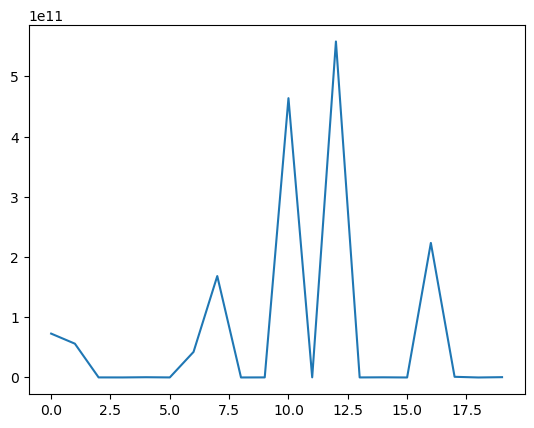

In [28]:
import matplotlib.pyplot as plt
plt.plot(train_losses)

In [29]:
constant_pi = torch.acos(torch.zeros(1)).item() * 2
constant_pi

3.1415927410125732

In [30]:
-0.5 * torch.log(2.0 * constant_pi * torch.ones(3, 4)*1e6)

tensor([[-7.8267, -7.8267, -7.8267, -7.8267],
        [-7.8267, -7.8267, -7.8267, -7.8267],
        [-7.8267, -7.8267, -7.8267, -7.8267]])

In [31]:
-torch.log(torch.ones(3, 4)* -0.0)

tensor([[inf, inf, inf, inf],
        [inf, inf, inf, inf],
        [inf, inf, inf, inf]])